[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pln-fing-udelar/retuyt-inco-huhu-2023/blob/main/finetuning_robertuito/train_finetuning_robertuito.ipynb)

# Fine-tuning Robertuito for the HUHU Shared Task

This notebook presents **how we trained** the fine-tuned versions of [pysentimiento/robertuito-base-uncased](https://huggingface.co/pysentimiento/robertuito-base-uncased) created for the HUHU Shared Task at IberLEF 2023. All models are available in [Hugging Face](https://huggingface.co/).

To run our already fine-tuned models, please refer to the notebook *run_finetuning_robertuito.ipynb*.

For this notebook, it is **recommended** to use a runtime with GPU enabled.

The Shared Task consisted of the following three subtasks (as explained in [the official website](https://sites.google.com/view/huhuatiberlef23/huhu)).

### Subtask 1: HUrtful HUmour Detection

The first subtask consists in determining whether a prejudicial tweet is intended to cause humour. Participants will have to distinguish between tweets that using humour express prejudice and tweets that express prejudice without using humour.

### Subtask 2A: Prejudice Target Detection

Taking into account the following minority groups: Women and feminists, LGBTIQ community and Immigrants, racially discriminated people, and overweight people, participants are asked to identify the targeted groups on each tweet as a multilabel classification task.

### Subtask 2B: Degree of Prejudice Prediction

The third subtask consists of predicting on a continuous scale from 1 to 5 to evaluate how prejudicial the message is on average among minority groups.

In [ ]:
#@title Install transformers package

!pip install transformers

In [11]:
#@title Auxiliary functions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def plotConfusionMatrix(labels, original, prediction):
    cm = confusion_matrix(original, prediction, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

def getFScorePerClass(labels, original, prediction):

    print("F-Score avg: " + str(round(f1_score(original, prediction, average='macro'), 3)))

    scores = f1_score(original, prediction, average=None, labels=labels)
    for i in range(len(labels)):
        print(f"F-Score for the {labels[i]} class: " + str(round(scores[i], 3)))

To run the following code, it is necessary to have the following files in the root of your directory structure:


*   huhu_split_train.csv
*   huhu_split_dev.csv

In our experiments, we decided to make our own internal 90%-10% split of the training set that was made available by the organizers. This training set can be downloaded from [zenodo](https://zenodo.org/record/7967255).


In [3]:
#@title Load train_set and dev_set
import pandas as pd

train_set = pd.read_csv('huhu_split_train.csv').sample(frac=1, random_state=1).reset_index()
dev_set = pd.read_csv('huhu_split_dev.csv')

## Subtasks 1 and 2A

In [13]:
#@title Select base model to use and category to learn

base_model = "pysentimiento/robertuito-base-uncased" #@param {"type":"string"}
category = "prejudice_woman" #@param ["humor", "prejudice_woman", "prejudice_lgbtiq", "prejudice_inmigrant_race", "gordofobia"]

In [14]:
#@title Preprocessing
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(base_model)

# If no pad_token is defined in the tokenizer, we define it as the eos token
tokenizer.pad_token = tokenizer.eos_token if not tokenizer.pad_token else tokenizer.pad_token

tokenized_data = tokenizer([tweet["tweet"] for _, tweet in train_set.iterrows()], return_tensors="np", padding=True)

# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
tokenized_data = dict(tokenized_data)

labels = np.array([tweet[category] for _, tweet in train_set.iterrows()])

In [15]:
#@title Train
from transformers import TFAutoModelForSequenceClassification, set_seed
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

seed = 1234 #@param {"type":"integer"}
epochs = 2 #@param {"type":"integer"}

# Make training reproducible
set_seed(seed)

# Load and compile the base model
model = TFAutoModelForSequenceClassification.from_pretrained(base_model, from_pt=True)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id if needed
model.config.pad_token_id = model.config.eos_token_id if not model.config.pad_token_id else model.config.pad_token_id

model.compile(optimizer=Adam(3e-5))

model.fit(tokenized_data, labels, epochs=epochs)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/2
76/76 [==============================] - 96s 619ms/step - loss: 0.3371
Epoch 2/2
76/76 [==============================] - 45s 596ms/step - loss: 0.1060


F-Score avg: 0.91
F-Score for the negative class: 0.909
F-Score for the positive class: 0.911


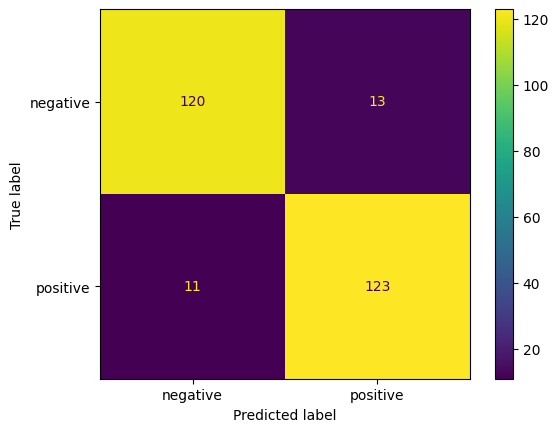

In [16]:
#@title Evaluate model
import tensorflow as tf

# Tokenize tweets in dev_set
tokenized_dev = tokenizer([tweet["tweet"] for _, tweet in dev_set.iterrows()], return_tensors="np", padding=True)
tokenized_dev = dict(tokenized_dev)

prediction = model(tokenized_dev)
prediction_logits = prediction[0]
prediction_probs = tf.nn.softmax(prediction_logits,axis=1).numpy()

original = ['positive' if x[category] == 1 else 'negative' for _, x in dev_set.iterrows()]
prediction = ['positive' if x[0] < x[1] else 'negative' for x in prediction_probs]

getFScorePerClass(['negative','positive'], original, prediction)
plotConfusionMatrix(['negative','positive'], original, prediction)

## Subtask 2B

Since this is a regression task, the head used for transfer learning is a classification head with one output label and the loss function is Mean Squared Error.

When evaluating the model, no function is applied to the output value.

In [17]:
#@title Select base model to use

base_model = "pysentimiento/robertuito-base-uncased" #@param {"type":"string"}

In [18]:
#@title Preprocessing
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(base_model)

# If no pad_token is defined in the tokenizer, we define it as the eos token
tokenizer.pad_token = tokenizer.eos_token if not tokenizer.pad_token else tokenizer.pad_token

tokenized_data = tokenizer([tweet["tweet"] for _, tweet in train_set.iterrows()], return_tensors="np", padding=True)

# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
tokenized_data = dict(tokenized_data)

labels = np.array([tweet["mean_prejudice"] for _, tweet in train_set.iterrows()])

In [19]:
#@title Train
from transformers import TFAutoModelForSequenceClassification, set_seed
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

seed = 1234 #@param {"type":"integer"}
epochs = 4 #@param {"type":"integer"}

# Make training reproducible
set_seed(seed)

# Load and compile the base model
model = TFAutoModelForSequenceClassification.from_pretrained(base_model, from_pt=True, num_labels=1)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id if needed
model.config.pad_token_id = model.config.eos_token_id if not model.config.pad_token_id else model.config.pad_token_id

model.compile(optimizer=Adam(3e-5), loss=tf.keras.losses.MeanSquaredError())

model.fit(tokenized_data, labels, epochs=epochs)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/4
76/76 [==============================] - 98s 627ms/step - loss: 1.2750
Epoch 2/4
76/76 [==============================] - 45s 593ms/step - loss: 0.4855
Epoch 3/4
76/76 [==============================] - 45s 597ms/step - loss: 0.3276
Epoch 4/4
76/76 [==============================] - 45s 597ms/step - loss: 0.1917


In [21]:
#@title Evaluate model
import tensorflow as tf
from sklearn.metrics import mean_squared_error

# Tokenize tweets in dev_set
tokenized_dev = tokenizer([tweet["tweet"] for _, tweet in dev_set.iterrows()], return_tensors="np", padding=True)
tokenized_dev = dict(tokenized_dev)

prediction = model(tokenized_dev)[0]
original = [x["mean_prejudice"] for _, x in dev_set.iterrows()]

print("RMSE:", mean_squared_error(prediction, original, squared=False))

RMSE: 0.7620399360144476
